<a href="https://colab.research.google.com/github/princexoleo/machine-learning/blob/master/pneumonia_chest_x_ray_with_pytorch_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#install  kaggle dependencies
!pip install kaggle

For kaggle authentication 

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mazleon","key":"363f2f7fd8692add55876ab33f0ad533"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# change the permission
!chmod 600 ~/.kaggle/kaggle.json

Kaggle datasets download link copy from kaggle websites

In [0]:
# Kaggle datasets url link paste here ..
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:36<00:00, 46.1MB/s]
100% 2.29G/2.29G [00:36<00:00, 68.0MB/s]


For Extracting datasets

In [0]:
from zipfile import ZipFile
file_name = "chest-xray-pneumonia.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")

Done


Data directory

In [0]:
data_dir = "/content/chest_xray/chest_xray"
train_dir = data_dir+'/train'
test_dir = data_dir+'/test'
valid_dir = data_dir+'/val'

Import some important libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets,transforms, models

Define Some Transformations for Training, Validation and Testing sets

In [0]:
training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225 ])
                                          ])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225 ])
                                          ])

testing_transforms = transforms.Compose([transforms.Resize(256),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225 ])
                                          ])

In [0]:
from torch.utils.data import Dataset, DataLoader

Load imgae from folder and transform

In [0]:
training_datasets = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_datasets = datasets.ImageFolder(valid_dir, transform=validation_transforms)
testing_datasets = datasets.ImageFolder(test_dir, transform=testing_transforms)

In [0]:
train_loader = DataLoader(training_datasets, batch_size=64, shuffle=True)
valid_loader = DataLoader(validation_datasets, batch_size=32)
test_loader = DataLoader(testing_datasets, batch_size=32)

In [0]:
print(len(train_loader))

82


In [0]:
model = models.resnet50(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

For customize models

In [0]:
for parameter in model.parameters():
  parameter.requires_grad = False

In [0]:
from collections import OrderedDict

# Build custom classifier
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 2)),
                                        ('output', nn.LogSoftmax(dim=1))]))

model.classifier = classifier

In [0]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
# Function for the validation 
def validation(model, validloader, criterion):
  val_loss = 0
  accuracy = 0

  for images, labels in iter(validloader):
    images, labels = images.to('cuda'), labels.to('cuda')

    output = model.forward(images)
    val_loss += criterion(output, labels).item()

    probabilities = torch.exp(output)
    equlity = (labels.data==probabilities.max(dim=1)[1])
    accuracy += equlity.type(torch.FloatTensor).mean()

  return val_loss, accuracy


In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [0]:
from tqdm import tqdm

In [0]:
#Train Classifier

def train_classifier():
  epochs = 10
  steps = 0
  print_every = 30
  model.to('cuda')

  for e in range(epochs):
    model.train()
    running_loss = 0

    for images, labels in iter(train_loader):
      steps += 1
      images, labels = images.to('cuda'), labels.to('cuda')
      optimizer.zero_grad()

      output = model.forward(images)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()

      running_loss +=loss.item()

      if steps % print_every == 0:
        model.eval()
        with torch.no_grad():
          validation_loss , accuracy = validation(model, valid_loader, criterion)
        print("Epochs: {}/{}.. ".format(e+1, epochs),
                "Traning Loss: {:.3f}.. ".format(running_loss/print_every),
                "Validation Loss: {:.3f}.. ".format(validation_loss/len(valid_loader)),
                "Validation Accuracy: {:.3f}.. ".format(accuracy/len(valid_loader)))
          
        running_loss = 0
        model.train()
  



In [0]:
train_classifier()

Epochs: 1/10..  Traning Loss: 0.502..  Validation Loss: 2.002..  Validation Accuracy: 0.000.. 
Epochs: 1/10..  Traning Loss: 0.493..  Validation Loss: 1.214..  Validation Accuracy: 0.000.. 
Epochs: 2/10..  Traning Loss: 0.126..  Validation Loss: 1.165..  Validation Accuracy: 0.000.. 
Epochs: 2/10..  Traning Loss: 0.506..  Validation Loss: 1.123..  Validation Accuracy: 0.000.. 
Epochs: 2/10..  Traning Loss: 0.462..  Validation Loss: 1.160..  Validation Accuracy: 0.000.. 
Epochs: 3/10..  Traning Loss: 0.273..  Validation Loss: 1.099..  Validation Accuracy: 0.000.. 


KeyboardInterrupt: ignored

# Using Fastai

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import Neccesary Library

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
import os

path directory

In [0]:
data_dir = "/content/chest_xray/chest_xray"
train_dir = data_dir+'/train'
test_dir = data_dir+'/test'
valid_dir = data_dir+'/val'

In [0]:
path = Path(data_dir)
path.ls()

[PosixPath('/content/chest_xray/chest_xray/test'),
 PosixPath('/content/chest_xray/chest_xray/train'),
 PosixPath('/content/chest_xray/chest_xray/.DS_Store'),
 PosixPath('/content/chest_xray/chest_xray/val')]

torch.Size([3, 1225, 1632])


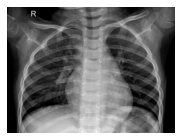

In [0]:
img = open_image(path/'val'/'NORMAL'/'NORMAL2-IM-1440-0001.jpeg')
print(img.data.shape)
img.show()

In [0]:
tfms = get_transforms()
bs = 64

In [0]:
np.random.seed(7)
data = ImageDataBunch.from_folder(path,
                                  valid ='val',
                                  valid_pct=0.2,
                                  size=299,
                                  bs = bs,
                                  ds_tfms=tfms).normalize(imagenet_stats)

show batch data


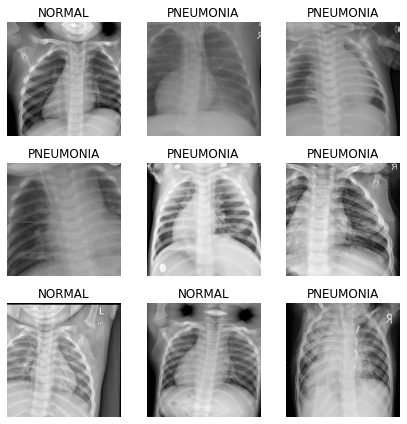

In [0]:
data.show_batch(3, figsize=(6,6))

In [0]:
print(data.classes)
print(data.c)
print(len(data.train_ds))
print(len(data.valid_ds))


['NORMAL', 'PNEUMONIA']
2
4685
1171


Model: resnet50

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
learn

Learner(data=ImageDataBunch;

Train: LabelList (4685 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: /content/chest_xray/chest_xray;

Valid: LabelList (1171 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA
Path: /content/chest_xray/chest_xray;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64,

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.458266,0.426974,0.088813,04:43
1,0.270707,0.246444,0.059778,04:37
2,0.185580,0.206074,0.065756,04:37
3,0.147048,0.162038,0.048676,04:35


In [0]:
# save the model with weights
learn.save('stage-1')

In [0]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


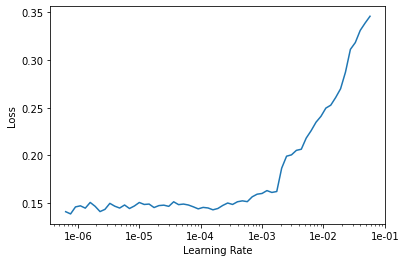

In [0]:
learn.recorder.plot()

In [65]:
learn.fit_one_cycle(10, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.076051,0.119889,0.029035,04:50
1,0.082704,0.188526,0.041845,04:44
2,0.089578,0.161053,0.046114,04:44
3,0.083956,0.102818,0.029035,04:44
4,0.085481,0.143702,0.034159,04:43
5,0.069385,0.124793,0.032451,04:48
6,0.046885,0.114037,0.031597,04:51
7,0.037000,0.094558,0.023911,04:51
8,0.031644,0.091326,0.022203,04:50
9,0.030144,0.094186,0.020495,04:54


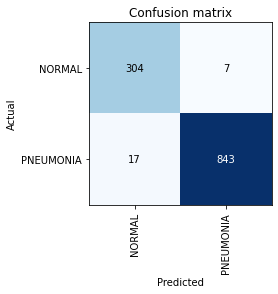

In [66]:
learn.save('stage-2')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()